In [27]:
# Reference taken from  https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb

In [4]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 1927, done.
remote: Counting objects: 100% (1927/1927), done.
remote: Compressing objects: 100% (1684/1684), done.
remote: Total 1927 (delta 444), reused 769 (delta 225), pack-reused 0
Receiving objects: 100% (1927/1927), 30.09 MiB | 29.86 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [6]:
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [7]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# get from label_map.pbtxt https://github.com/aberrya/WildFireSmokeDetection/blob/master/smoke_detection_model/DataSet/smoke_label_map.pbtxt
pbtxt_fname = "<Path to label_map.pbtxt>"
from object_detection.utils import label_map_util
label_map = label_map_util.load_labelmap(pbtxt_fname)
# label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
label_map

item {
  name: "smoke"
  id: 1
  display_name: "smoke"
}

In [ ]:
# Get model froma https://github.com/aberrya/WildFireSmokeDetection/tree/master/smoke_detection_model/fine_tuned_model/saved_model
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('<Path to saved model>/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 2.8585894107818604 second per image


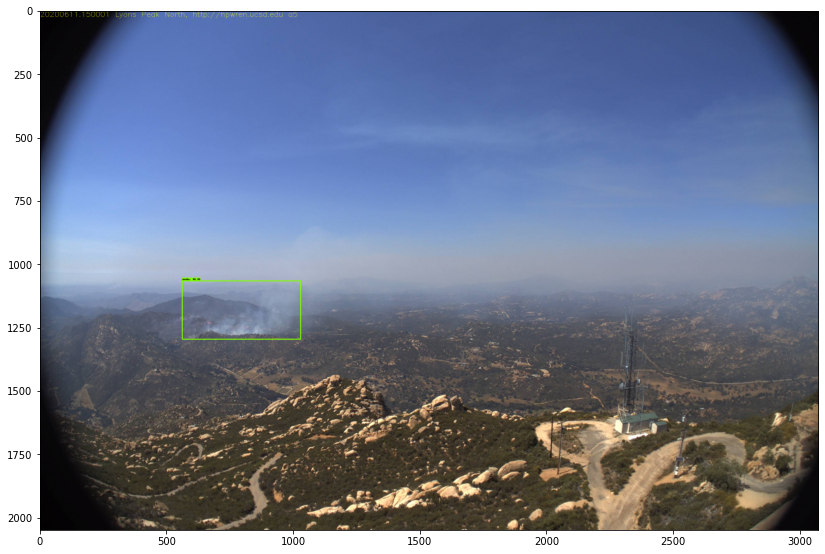

In [26]:
import time

image_dir = '/content/test_images'

elapsed = []
for i in range(2):
  image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=.70,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')